## импорт библиотек

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [82]:
from catboost import CatBoostRegressor

In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [86]:
from sklearn.model_selection import RandomizedSearchCV
import optuna

## импорт данных

In [89]:
test_df=pd.read_csv('test_mmsc.csv', sep = ';')
train_df=pd.read_csv('train_mmsc.csv', sep = ';')

In [90]:
x_train = train_df.drop('Unit_Price', axis=1)
y_train = train_df['Unit_Price']
x_test = test_df.drop('Unit_Price', axis=1)
y_test = test_df['Unit_Price']

In [93]:
test_df['Unit_Price'].describe()

count    29700.000000
mean         4.719276
std          2.766171
min          0.200000
25%          2.400000
50%          4.200000
75%          6.900000
max         13.600000
Name: Unit_Price, dtype: float64

# модель CatBoost

In [96]:
# определение категориальных признаков
categorical_features = ['Product_Name', 'Status', 'Category']

# преобразование типов данных
for col in categorical_features:
    train_df[col] = x_train[col].astype('category')


# преобразование типов данных 
for col in categorical_features:
    test_df[col] = x_test[col].astype('category')

In [98]:
# создание модели
catboost_model_1 = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          l2_leaf_reg = 1,
                          depth=8,
                          loss_function='RMSE',
                          random_seed=42,
                          verbose=100,
                          cat_features=categorical_features) # указываем категориальные признаки

#обучение модели
catboost_model_1.fit(x_train, y_train)

0:	learn: 2.4881320	total: 173ms	remaining: 2m 52s
100:	learn: 0.5263077	total: 12.4s	remaining: 1m 50s
200:	learn: 0.4656291	total: 24.4s	remaining: 1m 36s
300:	learn: 0.4391187	total: 37s	remaining: 1m 26s
400:	learn: 0.4197275	total: 48.5s	remaining: 1m 12s
500:	learn: 0.4068236	total: 1m 1s	remaining: 1m 1s
600:	learn: 0.3964749	total: 1m 14s	remaining: 49.3s
700:	learn: 0.3878478	total: 1m 27s	remaining: 37.1s
800:	learn: 0.3799970	total: 2m 6s	remaining: 31.4s
900:	learn: 0.3745525	total: 3m 9s	remaining: 20.8s
999:	learn: 0.3684122	total: 4m 11s	remaining: 0us


In [99]:
#предсказание модели по тестовой выборке

y_pred_1 = catboost_model_1.predict(x_test)

In [163]:
#функция для расчета всех метрик
def calculate_metrics(y_true, y_pred):
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    # WAPE
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    return {
        'MAE': mae,
        'WAPE': wape}

In [165]:
#оценка модели на тест данных
metrics_1 = calculate_metrics(y_test, y_pred_1)

#результаты
print("Метрики качества модели:")
print(f"MAE: {metrics_1['MAE']:.4f}")
print(f"WAPE: {metrics_1['WAPE']:.2f}%")

Метрики качества модели:
MAE: 0.3359
WAPE: 7.12%


##  сравнения истинных и предсказанных значений модели cat boost

In [107]:
#создание дф для сравнения истинных и предсказанных значений
results_df = pd.DataFrame({'Истинное значение': y_test, 'Предсказанное значение': y_pred_1})


#расчет разницы между предсказанным и истинным значениями
results_df['Разница'] = results_df['Предсказанное значение'] - results_df['Истинное значение']

#округление до 2 знаков после запятой
results_df['Истинное значение'] = results_df['Истинное значение'].round(2)
results_df['Предсказанное значение'] = results_df['Предсказанное значение'].round(2)
results_df['Разница'] = results_df['Разница'].round(2)

#расчет процентной ошибки
results_df['Процентная ошибка'] = np.abs(results_df['Разница'] / results_df['Истинное значение']) * 100
results_df['Процентная ошибка'] = results_df['Процентная ошибка'].replace([np.inf, np.nan], 0) # Замена inf и nan на 0
results_df['Процентная ошибка'] = results_df['Процентная ошибка'].round(2).astype(str) + '%'



results_df.sample(20, random_state=42)  



,Истинное значение,Предсказанное значение,Разница,Процентная ошибка
8211,5.7,6.00,0.30,5.26%
8218,6.0,5.71,-0.29,4.83%
25516,2.0,1.97,-0.03,1.5%
20841,3.0,2.49,-0.51,17.0%
13432,6.9,6.11,-0.79,11.45%
19594,5.3,5.04,-0.26,4.91%
1921,2.6,3.00,0.40,15.38%
9804,2.8,2.93,0.13,4.64%
8629,7.4,7.69,0.29,3.92%
19756,6.9,8.78,1.88,27.25%


In [109]:
#функция для визуализации результатов сравнения

def plot_deviations(results_df, sample_size=120):

        
    # Случайная выборка данных
    results_df_sample = results_df.sample(n=sample_size).reset_index(drop=True)
    
    # Создание графика отклонений
    plt.figure(figsize=(12, 6))
    
    # Точечные диаграммы
    plt.scatter(results_df_sample.index, results_df_sample['Истинное значение'], 
                label='Истинное значение', marker='o')
    plt.scatter(results_df_sample.index, results_df_sample['Предсказанное значение'], 
                label='Предсказанное значение', marker='x')
    
    # Соединение точек линиями
    for i in range(len(results_df_sample)):
        plt.plot([i, i], 
                 [results_df_sample['Истинное значение'][i], 
                  results_df_sample['Предсказанное значение'][i]], 
                 linestyle='--', color='gray', alpha=0.5)
    
    # Оформление графика
    plt.title(f'График отклонений ({sample_size} случайных значений): Истинные vs. Предсказанные значения')
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    
    plt.show()

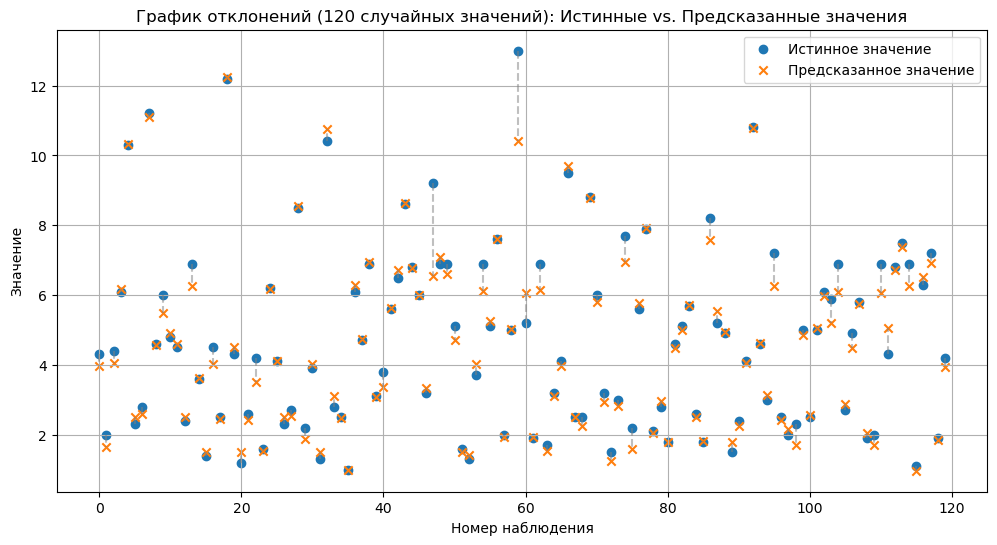

In [111]:
plot_deviations(results_df, 120)

## сохранение модели

In [114]:
catboost_model_1.save_model("catboost_model_1.cbm") 

# подбор параметров с помощью RandomizedSearchCV

In [117]:
# Параметры для настройки и их диапазоны
param_grid = {
    # Основные параметры оптимизации
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Скорость обучения
    'depth': [4, 6, 8, 10, 12],  # Глубина деревьев
    'iterations': [500, 1000, 1500, 2000],  # Количество итераций
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # L2-регуляризаци
    
    # Параметры функции потерь
    'loss_function': ['RMSE', 'MAE', 'Quantile'],  # Функция потерь
}

In [118]:
#модель CatBoost
model = CatBoostRegressor(random_seed=42, verbose=0, cat_features=categorical_features)

#создание объект RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  # Количество комбинаций для проверки
    scoring='neg_root_mean_squared_error',  # Метрика оценки
    cv=3,  # Количество фолдов для кросс-валидации
    random_state=42,  # Воспроизводимость результатов
    n_jobs=-1,  # Использование всех доступных ядер
    verbose=1  # Вывод прогресса
)

In [190]:
#запуск
randomized_search.fit(x_train, y_train)

#сохранение лучших результатов
best_params = randomized_search.best_params_

#результаты
print("Лучшие параметры:", best_params)
print("Лучший RMSE:", -randomized_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'loss_function': 'RMSE', 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 6}
Лучший RMSE: 0.47463409784239774


## обучение модели с найденными параметрами

In [192]:
#обучение второй модели на найденных параметрах

catboost_model_2 = CatBoostRegressor(
    **best_params,               # Распаковка лучших параметров
    random_seed=42,              # Фиксация случайности
    cat_features=categorical_features,  # Указание категориальных признаков
    verbose=100                   # Вывод логов каждые 100 итераций
)

#обучение
catboost_model_2.fit(x_train, y_train)

0:	learn: 2.4886485	total: 85.1ms	remaining: 1m 25s
100:	learn: 0.5745848	total: 8.27s	remaining: 1m 13s
200:	learn: 0.5115623	total: 17.1s	remaining: 1m 7s
300:	learn: 0.4845895	total: 26.6s	remaining: 1m 1s
400:	learn: 0.4662366	total: 35.8s	remaining: 53.4s
500:	learn: 0.4538960	total: 44.7s	remaining: 44.6s
600:	learn: 0.4447884	total: 53.8s	remaining: 35.7s
700:	learn: 0.4378791	total: 1m 3s	remaining: 26.9s
800:	learn: 0.4335614	total: 1m 12s	remaining: 18s
900:	learn: 0.4277554	total: 1m 20s	remaining: 8.86s
999:	learn: 0.4236597	total: 1m 29s	remaining: 0us


In [193]:
#оценка модели на тест данных
y_pred_2 = catboost_model_2.predict(x_test)

In [194]:
# Рассчитываем метрики для cat boost
metrics_2 = calculate_metrics(y_test, y_pred_2)

# Выводим результаты
print("Метрики качества модели:")
print(f"MAE: {metrics_2['MAE']:.4f}")
print(f"WAPE: {metrics_2['WAPE']:.2f}%")

Метрики качества модели:
MAE: 0.3317
WAPE: 7.03%


## сравнения истинных и предсказанных значений модели cat boost grid search

In [196]:
#создание дф для сравнения истинных и предсказанных значений
results_df_2 = pd.DataFrame({'Истинное значение': y_test, 'Предсказанное значение': y_pred_2})


#расчет разницы между предсказанным и истинным значениями
results_df_2['Разница'] = results_df_2['Предсказанное значение'] - results_df_2['Истинное значение']

#округление до 2 знаков после запятой
results_df_2['Истинное значение'] = results_df_2['Истинное значение'].round(2)
results_df_2['Предсказанное значение'] = results_df_2['Предсказанное значение'].round(2)
results_df_2['Разница'] = results_df_2['Разница'].round(2)


#расчет процентной ошибки
results_df_2['Процентная ошибка'] = np.abs(results_df_2['Разница'] / results_df_2['Истинное значение']) * 100
results_df_2['Процентная ошибка'] = results_df_2['Процентная ошибка'].replace([np.inf, np.nan], 0) 
results_df_2['Процентная ошибка'] = results_df_2['Процентная ошибка'].round(2).astype(str) + '%'


#вывод случайных строк
results_df_2.sample(20, random_state=42)  # Вывод первых 20 строк для примера

,Истинное значение,Предсказанное значение,Разница,Процентная ошибка
8211,5.7,5.95,0.25,4.39%
8218,6.0,5.66,-0.34,5.67%
25516,2.0,1.95,-0.05,2.5%
20841,3.0,2.48,-0.52,17.33%
13432,6.9,6.20,-0.70,10.14%
19594,5.3,5.02,-0.28,5.28%
1921,2.6,2.95,0.35,13.46%
9804,2.8,2.94,0.14,5.0%
8629,7.4,7.71,0.31,4.19%
19756,6.9,8.85,1.95,28.26%


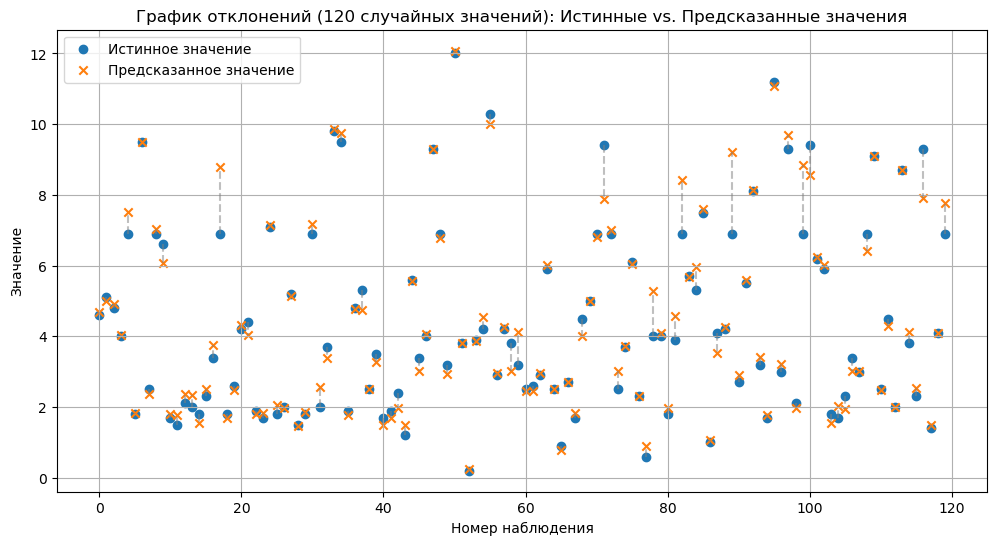

In [197]:
#визуализация дф
plot_deviations(results_df_2, 120)

## сохранение полученной модели

In [203]:
catboost_model_2.save_model("catboost_model_2.cbm") 

# подбор параметров с OPTUNA

In [66]:
# Функция для оптимизации
def objective(trial):
    
    params = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
        'depth': trial.suggest_categorical('depth', [4, 6, 8, 10, 12]),
        'iterations': trial.suggest_categorical('iterations', [500, 1000, 1500, 2000]),
        'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [1, 3, 5, 7, 9]),
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE', 'Quantile']),
        'random_seed': 42,
        'verbose': 0,
        'cat_features': categorical_features
    }
    
    # Создаем и обучаем модель
    model = CatBoostRegressor(**params)
    model.fit(x_train, y_train)
    
    # Делаем предсказания и вычисляем метрику
    y_pred = model.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse

In [ ]:
def early_stopping_callback(study, trial):
    # Останавливаем, если 5 последовательных попыток не улучшают результат
    if study.get_trials(deepcopy=False)[-5:].count(study.best_trial) == 0:
        study.stop()

study = optuna.create_study(direction='minimize')
study.optimize(
    objective,
    n_trials=50,
    callbacks=[early_stopping_callback]
)

[I 2025-05-09 05:53:33,417] A new study created in memory with name: no-name-95e2a51b-1c45-45bc-b9f1-3b2f7cfce109
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-05-09 06:02:16,270] Trial 0 finished with value: 0.6618154070810497 and parameters: {'learning_rate': 0.01, 'depth': 4, 'iterations': 2000, 'l2_leaf_reg': 7, 'loss_function': 'Quantile'}. Best is trial 0 with value: 0.6618154070810497.
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-05-09 06:04:26,958] Trial 1 finished with value: 0.6656444751342119 and parameters: {'learning_rate': 0.05, 'd

In [130]:
# Выводим лучшие параметры
print("Лучшие параметры:")
print(study.best_params)

Лучшие параметры:
{'learning_rate': 0.2, 'depth': 10, 'iterations': 500, 'l2_leaf_reg': 1, 'loss_function': 'Quantile'}


## обучение модели с найденными параметрами

In [133]:
# Создаем модель с лучшими параметрами
catboost_model_3 = CatBoostRegressor(**study.best_params, cat_features=categorical_features)
catboost_model_3.fit(x_train, y_train)

0:	learn: 0.9215569	total: 729ms	remaining: 6m 3s
1:	learn: 0.7782460	total: 1.57s	remaining: 6m 30s
2:	learn: 0.6674876	total: 2.51s	remaining: 6m 55s
3:	learn: 0.5688657	total: 3.29s	remaining: 6m 48s
4:	learn: 0.5012538	total: 4.09s	remaining: 6m 45s
5:	learn: 0.4559294	total: 4.4s	remaining: 6m 2s
6:	learn: 0.3957938	total: 4.88s	remaining: 5m 43s
7:	learn: 0.3531261	total: 5.13s	remaining: 5m 15s
8:	learn: 0.3162731	total: 5.3s	remaining: 4m 48s
9:	learn: 0.2875409	total: 5.63s	remaining: 4m 35s
10:	learn: 0.2655475	total: 6.42s	remaining: 4m 45s
11:	learn: 0.2498169	total: 7.18s	remaining: 4m 51s
12:	learn: 0.2368435	total: 7.95s	remaining: 4m 57s
13:	learn: 0.2257005	total: 8.66s	remaining: 5m
14:	learn: 0.2181319	total: 9.45s	remaining: 5m 5s
15:	learn: 0.2121733	total: 10.2s	remaining: 5m 8s
16:	learn: 0.2070777	total: 10.9s	remaining: 5m 9s
17:	learn: 0.2038979	total: 11.7s	remaining: 5m 12s
18:	learn: 0.2025934	total: 12.2s	remaining: 5m 9s
19:	learn: 0.1998736	total: 13s	re

In [137]:
#оценка модели на тест данных

y_pred_3 = catboost_model_3.predict(x_test)

In [169]:
# Рассчитываем метрики для cat boost
metrics_3 = calculate_metrics(y_test, y_pred_3)

# Выводим результаты
print("Метрики качества модели:")
print(f"MAE: {metrics_3['MAE']:.4f}")
print(f"WAPE: {metrics_3['WAPE']:.2f}%")

Метрики качества модели:
MAE: 0.2835
WAPE: 6.01%


## сравнение истинных и предсказанных значений

In [172]:
#создание дф для сравнения истинных и предсказанных значений
results_df_3 = pd.DataFrame({'Истинное значение': y_test, 'Предсказанное значение': y_pred_3})


#расчет разницы между предсказанным и истинным значениями
results_df_3['Разница'] = results_df_3['Предсказанное значение'] - results_df_3['Истинное значение']

#округление до 2 знаков после запятой
results_df_3['Истинное значение'] = results_df_3['Истинное значение'].round(2)
results_df_3['Предсказанное значение'] = results_df_3['Предсказанное значение'].round(2)
results_df_3['Разница'] = results_df_3['Разница'].round(2)


#расчет процентной ошибки
results_df_3['Процентная ошибка'] = np.abs(results_df_3['Разница'] / results_df_3['Истинное значение']) * 100
results_df_3['Процентная ошибка'] = results_df_3['Процентная ошибка'].replace([np.inf, np.nan], 0) 
results_df_3['Процентная ошибка'] = results_df_3['Процентная ошибка'].round(2).astype(str) + '%'


#вывод случайных строк
results_df_3.sample(20, random_state=42)  # Вывод первых 20 строк для примера

,Истинное значение,Предсказанное значение,Разница,Процентная ошибка
8211,5.7,5.86,0.16,2.81%
8218,6.0,5.74,-0.26,4.33%
25516,2.0,2.02,0.02,1.0%
20841,3.0,2.56,-0.44,14.67%
13432,6.9,6.40,-0.50,7.25%
19594,5.3,5.08,-0.22,4.15%
1921,2.6,2.94,0.34,13.08%
9804,2.8,2.93,0.13,4.64%
8629,7.4,7.79,0.39,5.27%
19756,6.9,7.26,0.36,5.22%


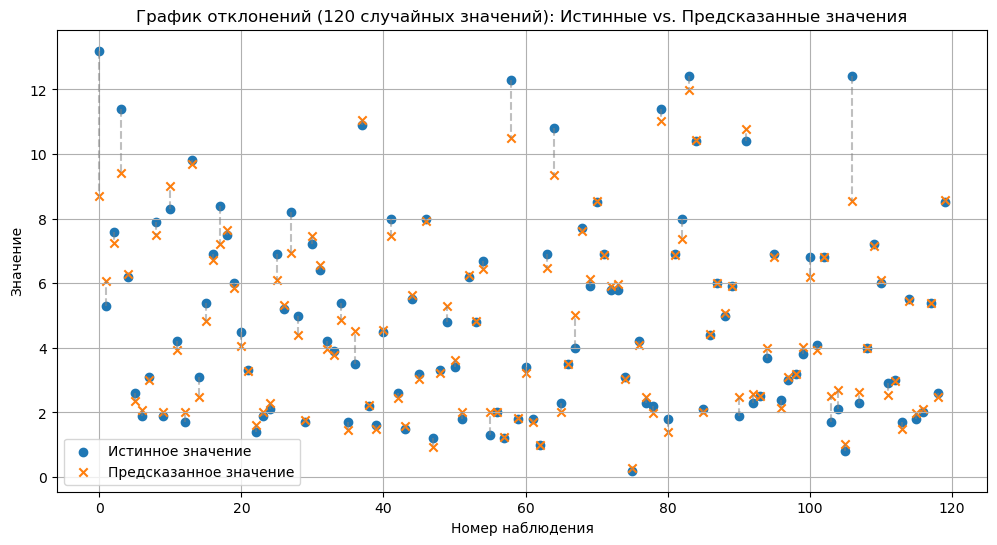

In [174]:
#визуализация 
plot_deviations(results_df_3, 120)

## сохранение модели

In [176]:
catboost_model_3.save_model("catboost_model_3.cbm") 

In [220]:
catboost_model_3.feature_names_

['Product_Name',
 'Stock_Quantity',
 'Reorder_Level',
 'Reorder_Quantity',
 'Sales_Volume',
 'Inventory_Turnover_Rate',
 'Status',
 'Category',
 'Average_Price_Per_Category',
 'Average_Price_Per_Product_Name',
 'Price_to_Sales_Ratio',
 'Day_of_Week',
 'Month']

In [228]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69300 entries, 0 to 69299
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Product_Name                    69300 non-null  category
 1   Stock_Quantity                  69300 non-null  float64 
 2   Reorder_Level                   69300 non-null  float64 
 3   Reorder_Quantity                69300 non-null  float64 
 4   Unit_Price                      69300 non-null  float64 
 5   Sales_Volume                    69300 non-null  float64 
 6   Inventory_Turnover_Rate         69300 non-null  float64 
 7   Status                          69300 non-null  category
 8   Category                        69300 non-null  category
 9   Average_Price_Per_Category      69300 non-null  float64 
 10  Average_Price_Per_Product_Name  69300 non-null  float64 
 11  Price_to_Sales_Ratio            69300 non-null  float64 
 12  Day_of_Week       

# сравнение метрик моделей

In [205]:

# Создаем базовый датафрейм
results_df = pd.DataFrame({
    'Реальные значения': y_test,
    'Предсказания CatBoost': y_pred_1.round(2),
    'Предсказания CatBoost с GridSearch': y_pred_2.round(2),
    'Предсказания CatBoost с Optuna': y_pred_3.round(2)
})

# Добавляем расчетные колонки
for model in ['CatBoost', 'CatBoost с GridSearch', 'CatBoost с Optuna']:
    results_df[f'Разница {model}'] = (results_df[f'Предсказания {model}'] - results_df['Реальные значения']).round(2)


# Выводим результат
results_df.sample(10)

,Реальные значения,Предсказания CatBoost,Предсказания CatBoost с GridSearch,Предсказания CatBoost с Optuna,Разница CatBoost,Разница CatBoost с GridSearch,Разница CatBoost с Optuna
7770,0.9,0.93,1.00,1.17,0.03,0.10,0.27
20889,6.9,6.03,6.50,6.77,-0.87,-0.40,-0.13
20848,4.8,3.90,3.96,3.91,-0.90,-0.84,-0.89
10608,6.9,6.10,6.16,6.39,-0.80,-0.74,-0.51
25617,4.7,4.72,4.71,4.69,0.02,0.01,-0.01
27707,8.1,8.35,8.12,8.18,0.25,0.02,0.08
29415,4.1,4.25,4.27,4.20,0.15,0.17,0.10
16407,3.4,3.50,3.53,3.47,0.10,0.13,0.07
27086,5.6,5.63,5.55,5.55,0.03,-0.05,-0.05
17575,4.8,4.05,3.94,4.10,-0.75,-0.86,-0.70


In [207]:
# Создаем датафрейм через словарь словарей
metrics_df = pd.DataFrame({
    'MAE': {
        'CatBoost': metrics_1['MAE'],
        'CatBoost GridSearch': metrics_2['MAE'],
        'CatBoost Optuna': metrics_3['MAE']
    },
    'WAPE': {
        'CatBoost': metrics_1['WAPE'],
        'CatBoost GridSearch': metrics_2['WAPE'],
        'CatBoost Optuna': metrics_3['WAPE']
    }

}).round(3)

In [209]:
metrics_df

,MAE,WAPE
CatBoost,0.336,7.117
CatBoost GridSearch,0.332,7.028
CatBoost Optuna,0.283,6.007


# выводы по моделям

In [212]:
test_df['Unit_Price'].describe()

count    29700.000000
mean         4.719276
std          2.766171
min          0.200000
25%          2.400000
50%          4.200000
75%          6.900000
max         13.600000
Name: Unit_Price, dtype: float64

In [214]:
# Создаем базовый датафрейм
results_df_56 = pd.DataFrame({
    'Реальные значения': y_test,
    'Предсказания CatBoost': y_pred_1.round(2),
    'Предсказания CatBoost с GridSearch': y_pred_2.round(2),
    'Предсказания CatBoost с Optuna': y_pred_3.round(2)
})

In [218]:
results_df_56
results_df_56.to_csv('cbr_results.csv', sep = ';', index=True)